<a href="https://colab.research.google.com/github/lej4545/AI_Project_Mask_Detection/blob/main/02_Projects/0825_LeeEunJin_Densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow import keras # 텐서플로우 임포트
keras.__version__ # 버전 확인

'2.6.0'

In [ ]:
from google.colab import drive # 구글 드라이브에서 구글 colab 연동

In [ ]:
drive.mount('/content/drive') # 구글 드라이브 마운트

Mounted at /content/drive


In [ ]:
import os # os모듈 임포트
for dirname, _, filenames in os.walk('/content/drive/My Drive/PART1_ai_project_20210824_0830/02_Projects/03_LeeEunJin'):
    for filename in filenames: # 아마도 위에 폴더 안에 있는 파일들을 불러와서 
        os.path.join(dirname, filename) # 폴더 이름과 파일 이름을 합쳐주는 것 같다.

In [ ]:
import pandas as pd # 필요한 묘둘 임포트
import numpy as np
import seaborn as sns
from pandas import DataFrame

In [ ]:
traindir='/content/drive/My Drive/PART1_ai_project_20210824_0830/01_Images/Train' # 학습할 데이터가 들어있는 폴더 경로
validdir='/content/drive/My Drive/PART1_ai_project_20210824_0830/01_Images/Validation' #  검증하기 위한 데이터가 들어있는 폴더 경로
testdir='/content/drive/My Drive/PART1_ai_project_20210824_0830/01_Images/Test' # 테스트 데이터가 들어있는 폴더 경로

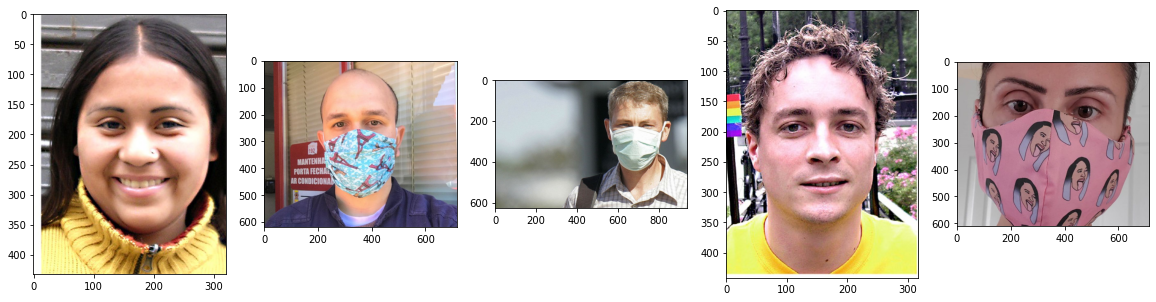

In [ ]:
path='/content/drive/My Drive/PART1_ai_project_20210824_0830/01_Images/All'# 모든 이미지가 담겨있는 폴더
import cv2 
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(20,20)) # 잘 불러오는지 확인하기 위해 임의의 5장 사진 출력
for i in range(5):
    file=random.choice(os.listdir(path)) # 디렉토리에 있는 파일 리스트를 가져온다.
    img_path=os.path.join(path,file)
    image=mpimg.imread(img_path)
    ax=plt.subplot(1,5,i+1)
    plt.imshow(image)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img #imagedatagenerator 임포트

# train_data, test_data 전처리
train_data=ImageDataGenerator(rescale=1.0/255, zoom_range=0.2, shear_range=0.2)


# 이미지를 불러올 때 폴더명에 맞춰 자동으로 labelling 해준다.('WithMask' : 0 ,'WithoutMask' : 1) 이미지 사이즈는 256* 256, 배치 사이즈는 32
train_generator = train_data.flow_from_directory(directory=traindir,target_size=(256, 256),class_mode='binary',batch_size=32)
test_data=ImageDataGenerator(rescale=1.0/255) 
# valid generator 도 train generator와 마찬가지로 진행
valid_generator = test_data.flow_from_directory(directory=validdir,target_size=(256, 256),class_mode='binary',batch_size=32)
# test 데이터도 train generator 에서 진행한 방식과 동일하고 추가적으로 rescaling을 진행
test_generator = test_data.flow_from_directory(directory=testdir,target_size=(256, 256),class_mode='binary',batch_size=32,shuffle=False)

print(valid_generator.class_indices)

Found 600 images belonging to 2 classes.
Found 306 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
{'WithMask': 0, 'WithoutMask': 1}


In [ ]:
from tensorflow.keras import layers, Sequential
from keras.applications.densenet import DenseNet201 # Densenet 모델 적용
from keras.applications.densenet import preprocess_input

# 사전 교육된 기본 모델 생성 
densenet201 = DenseNet201(weights='imagenet',include_top=False,input_shape=(256, 256,3))  

for layer in densenet201.layers: # <=이건 잘 모르겠다
    layer.trainable = False


vmodel = Sequential() # vmodel 모형 작성
vmodel.add(densenet201) # densenet201 기반 모델 추가

# 밑에 두개의 과정(Flatten, Dense) 이 densenet에서 진행되는지 조사가 필요함

vmodel.add(layers.Flatten()) # 평평하게 만들어 Denser 레이어로 전환을 하기 위함. 
vmodel.add(layers.Dense(1,activation='sigmoid')) #
vmodel.summary()
# shape와 param 가 왜 이렇게 나오는지 분석 필요함.

vmodel.compile(optimizer='adam',loss='binary_crossentropy', metrics='accuracy')

74850304/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 2, 2, 1920)        18321984  
_________________________________________________________________
flatten (Flatten)            (None, 7680)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 7681      
Total params: 18,329,665
Trainable params: 7,681
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
# 데이터 학습
history = vmodel.fit(train_generator,steps_per_epoch=len(train_generator)//8,epochs=20,validation_data=valid_generator, batch_size = 100)


Epoch 1/20
2/2 [==============================] - 213s 188s/step - loss: 1.3319 - accuracy: 0.5000 - val_loss: 1.4107 - val_accuracy: 0.4967
Epoch 2/20
2/2 [==============================] - 27s 17s/step - loss: 0.8821 - accuracy: 0.5536 - val_loss: 0.6829 - val_accuracy: 0.6634
Epoch 3/20
2/2 [==============================] - 28s 19s/step - loss: 0.6312 - accuracy: 0.7188 - val_loss: 0.6602 - val_accuracy: 0.7190
Epoch 4/20
2/2 [==============================] - 24s 18s/step - loss: 0.5341 - accuracy: 0.7500 - val_loss: 0.4383 - val_accuracy: 0.8170
Epoch 5/20
2/2 [==============================] - 20s 14s/step - loss: 0.4187 - accuracy: 0.7812 - val_loss: 0.3984 - val_accuracy: 0.8497
Epoch 6/20
2/2 [==============================] - 22s 16s/step - loss: 0.3206 - accuracy: 0.8750 - val_loss: 0.4040 - val_accuracy: 0.8562
Epoch 7/20
2/2 [==============================] - 14s 11s/step - loss: 0.3527 - accuracy: 0.9062 - val_loss: 0.3560 - val_accuracy: 0.8693
Epoch 8/20
2/2 [=========

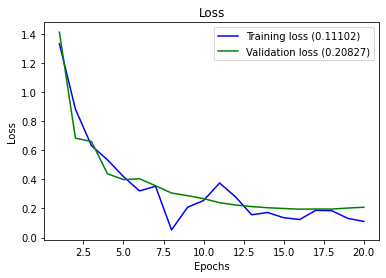

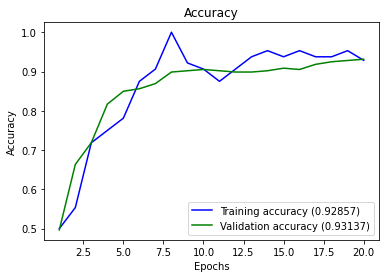

In [ ]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
plot_history(history)

Mask detected


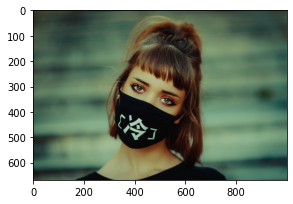

In [ ]:
from PIL import Image
import tensorflow as tf

img='/content/drive/My Drive/PART1_ai_project_20210824_0830/01_Images/Test/WithMask/2070.jpg'
plt.figure(figsize=(10,10))
image=Image.open(img)
ax=plt.subplot(1,2,1)
plt.imshow(image)
image=np.resize(image,(1,64,64,3))
image = image.astype('float32')
image /= 255  

if vmodel.predict(image)[0][0]<0.5:
    print("Mask detected")
else:
    print("No mask detected")